## Importing necessary packages and data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Load the treasury data from selected quotes sheet
data = pd.read_excel('data/treasury_quotes_2025-11-28.xlsx', sheet_name= 'selected quotes')

# Display the first few rows of the data
data.head()

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,total size,duration
0,208227,note,2025-11-28,2024-05-31,2026-05-31,0.503765,0.989071,4.875,100.521406,100.531220,100.526313,2.410861,102.937174,0.038263,7.142500e+10,0.492305
1,208316,note,2025-11-28,2024-11-30,2026-11-30,1.004791,0.989071,4.250,100.572266,100.591764,100.582015,2.101776,102.683791,0.036575,7.314900e+10,0.974601
2,208399,note,2025-11-28,2025-05-31,2027-05-31,1.503080,0.989071,3.875,100.453125,100.472656,100.462891,1.916325,102.379216,0.035621,7.844000e+10,1.448055
3,208484,note,2025-11-28,2025-11-30,2027-11-30,2.004107,0.000000,3.375,99.765625,99.769531,99.767578,0.000000,99.767578,0.034889,NaN,1.956136
4,208058,note,2025-11-28,2023-05-31,2028-05-31,2.505133,0.989071,3.625,100.312500,100.332031,100.322266,1.792691,102.114957,0.034901,4.936300e+10,2.376588


## 1.1 Bootstrap the Spot Curve

### Cashflow Matrix

In [3]:
# Create a grid of payment dates
payment_dates = sorted(data['maturity date'].unique())

# Initialize the matrix with zeros
n_bonds = len(data)
n_dates = len(payment_dates)
C = np.zeros((n_bonds, n_dates))

for i, row in data.iterrows():
    # Semi-annual coupon
    coupon = row['cpn rate'] / 2
    
    # Find the index of this bond's maturity in our column list
    mat_idx = payment_dates.index(row['maturity date'])
    
    # Fill coupons backwards from maturity to the beginning
    C[i, :mat_idx+1] = coupon
    
    # Add face value to the maturity date
    C[i, mat_idx] += 100

# Convert the cashflow matrix to a pandas DataFrame
cashflows = pd.DataFrame(C, index=data['KYTREASNO'], columns=payment_dates)

# Display the cashflow matrix
cashflows

,2026-05-31,2026-11-30,2027-05-31,2027-11-30,2028-05-31,2028-11-30,2029-05-31,2029-11-30,2030-05-31,2030-11-30,2031-05-31,2031-11-30,2032-05-31,2032-11-30,2033-05-15,2033-11-15,2034-05-15,2034-11-15,2035-05-15,2035-11-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,
208227,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208316,2.1250,102.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208399,1.9375,1.9375,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208484,1.6875,1.6875,1.6875,101.6875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208058,1.8125,1.8125,1.8125,1.8125,101.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208145,2.1875,2.1875,2.1875,2.1875,2.1875,102.1875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208229,2.2500,2.2500,2.2500,2.2500,2.2500,2.2500,102.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208318,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208401,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,102.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0


### Spot Discount Factor

In [4]:
# Create a vector of prices
price_vec = data['price']

# Solve p = Cz
z = np.linalg.solve(cashflows, price_vec)
data['discount_factor'] = z

# Display maturity date and discount factor
data[['maturity date', 'discount_factor']]

,maturity date,discount_factor
0,2026-05-31,0.981343
1,2026-11-30,0.964472
2,2027-05-31,0.948551
3,2027-11-30,0.933088
4,2028-05-31,0.917225
5,2028-11-30,0.901050
6,2029-05-31,0.884954
7,2029-11-30,0.868448
8,2030-05-31,0.852545
9,2030-11-30,0.836465


### Discount Rates

In [5]:
# Using the existing 'ttm' column for time to maturity
time_grid = data['ttm'].values
T = time_grid

# Calculate Rates from Discount Factors
z = data['discount_factor'].values

# Semiannually compounded rate
r_semi = 2 * ((1/z)**(1/(2*T)) - 1)

# Continuously compounded rate
r_cont = -np.log(z) / T

In [6]:
# Tuple of Time to Maturity, Discount Factor, Semiannually Compounded Spot Rate, Continuously Compounded Spot Rate
ttm_values = zip(T, z, r_semi, r_cont)

# Create a DataFrame from the tuples
spot_rates = pd.DataFrame(ttm_values, columns=['ttm', 'discount_factor', 'r_semi', 'r_cont'])

# Round the ttm to 1 decimal place
spot_rates['ttm'] = spot_rates['ttm'].round(1)

# Display the values for maturity 5 years
spot_rates[spot_rates['ttm'] == 5].round(4)

,ttm,discount_factor,r_semi,r_cont
9,5.0,0.8365,0.036,0.0357


In [7]:
spot_rates

,ttm,discount_factor,r_semi,r_cont
0,0.5,0.981343,0.037737,0.037385
1,1.0,0.964472,0.036328,0.036002
2,1.5,0.948551,0.035452,0.035141
3,2.0,0.933088,0.034857,0.034557
4,2.5,0.917225,0.034789,0.034490
5,3.0,0.901050,0.034962,0.034660
6,3.5,0.884954,0.035181,0.034876
7,4.0,0.868448,0.035526,0.035214
8,4.5,0.852545,0.035737,0.035421
9,5.0,0.836465,0.036000,0.035680


## 1.2 Forward Discount Factors

In [8]:
# Calculate 6-month forward rates for each maturity
forward_results = []

for i, row in spot_rates.iterrows():
    T = row['ttm']
    T_next = round(T + 0.5, 1)
    
    # Find the discount factor at T + 0.5
    match = spot_rates[spot_rates['ttm'] == T_next]
    
    if not match.empty:
        Z_T = row['discount_factor']
        Z_T_next = match['discount_factor'].values[0]
        
        # Forward discount factor: F(0, T, T+0.5) = Z(T+0.5) / Z(T)
        fwd_factor = Z_T_next / Z_T
        
        # Forward rate (semi-annual): f = 2 * ((1/F) - 1)
        fwd_semi = 2 * ((1 / fwd_factor) - 1)
        
        # Forward rate (continuous): f = -ln(F) / dt
        fwd_cont = -np.log(fwd_factor) / 0.5
        
        forward_results.append({
            'T': T,
            'forward discount': fwd_factor,
            'forward rate (semi-annual)': fwd_semi,
            'forward rate (continuous)': fwd_cont
        })

forward_df = pd.DataFrame(forward_results)

forward_df

,T,forward discount,forward rate (semi-annual),forward rate (continuous)
0,0.5,0.982808,0.034986,0.034683
1,1.0,0.983493,0.033569,0.033291
2,1.5,0.983698,0.033144,0.032872
3,2.0,0.983000,0.034587,0.034292
4,2.5,0.982365,0.035902,0.035584
5,3.0,0.982136,0.036378,0.036051
6,3.5,0.981348,0.038014,0.037657
7,4.0,0.981688,0.037307,0.036963
8,4.5,0.981140,0.038446,0.038081
9,5.0,0.978690,0.043549,0.043081


In [9]:
# Display forward rates table
display_columns = ['T', 'forward discount', 'forward rate (semi-annual)', 'forward rate (continuous)']

# Show specific row for T=5
forward_df.loc[forward_df['T'] == 5.0, display_columns].round(4)

,T,forward discount,forward rate (semi-annual),forward rate (continuous)
9,5.0,0.9787,0.0435,0.0431


## 1.3: Forward Curve Analysis

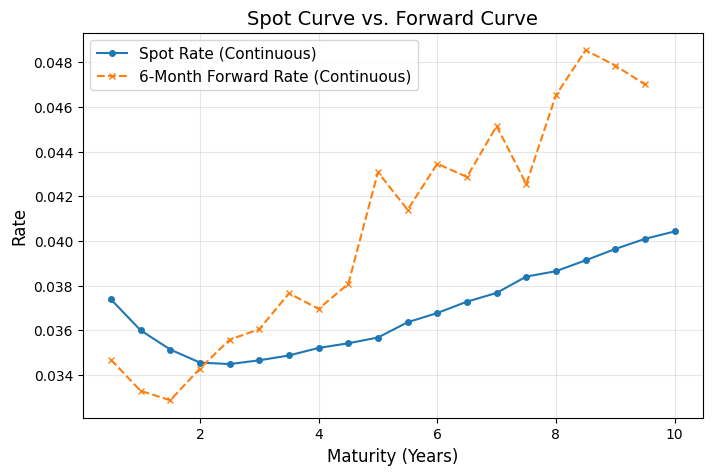

In [10]:
# Plot spot rate curve vs 6-month forward rate curve
plt.figure(figsize=(8, 5))

plt.plot(spot_rates['ttm'], spot_rates['r_cont'], 
         label='Spot Rate (Continuous)', marker='o', linestyle='-', markersize=4)

plt.plot(forward_df['T'], forward_df['forward rate (continuous)'], 
         label='6-Month Forward Rate (Continuous)', marker='x', linestyle='--', markersize=4)

plt.title('Spot Curve vs. Forward Curve', fontsize=14)
plt.xlabel('Maturity (Years)', fontsize=12)
plt.ylabel('Rate', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

### Highest Forward Rate

In [11]:
# Identify the maturity interval with the highest forward rate
max_idx = forward_df['forward rate (continuous)'].idxmax()
max_row = forward_df.loc[max_idx]

# Create a pretty dataframe for the highest forward rate
highest_fwd_df = pd.DataFrame({
    'Starting Maturity (years)': [max_row['T']],
    'Interval': [f"[{max_row['T']:.1f}, {max_row['T'] + 0.5:.1f}]"],
    'Forward Rate (continuous)': [max_row['forward rate (continuous)']],
    'Forward Discount': [max_row['forward discount']]
})

highest_fwd_df

,Starting Maturity (years),Interval,Forward Rate (continuous),Forward Discount
0,8.5,"[8.5, 9.0]",0.048544,0.97602


**Question:** At maturities where the forward rate is above the spot rate, what does this imply about the slope of the spot curve?

**Answer:**
When the **forward rate is above the spot rate**, the spot curve is **upward sloping** (positive gradient).



**Economic and Mathematical Intuition:**
* **Marginal vs. Average:** The spot rate represents the **average** rate of return from today to maturity. The forward rate represents the **marginal** rate added by extending the maturity by another six months.
* **The Pull Effect:** If the marginal rate (forward) is higher than the current average (spot), it "pulls" the average upward. Conversely, if the forward rate were lower than the spot rate, the spot curve would be downward sloping.
* **Calculus Identity:** This is defined by the relationship:
    $$f(0,T) = r(0,T) + T \frac{\partial r(0,T)}{\partial T}$$
    If $f(0,T) > r(0,T)$, then the slope $\frac{\partial r}{\partial T}$ must be greater than zero.